<a href="https://colab.research.google.com/github/l3ft-debug/NVIDIA-Historical-Stock-Price-Data/blob/main/Price_Trend_Analysis_NVIDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA Price Trend Analysis

This notebook provides a comprehensive analysis of NVIDIA's historical stock prices, including:

- Daily, monthly, and yearly closing price trends
- Comparison of long-term growth vs. short-term fluctuations
- Overlaying moving averages (50-day, 200-day)
- Daily returns & volatility analysis
- Volume vs. price movement investigation
- High-low (intraday range) analysis
- Yearly & monthly seasonality of returns
- Seasonal heatmap of returns

Upload your NVIDIA historical data CSV file to get started.

In [1]:
# Install missing dependencies (if needed)
!pip install seaborn plotly --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Upload the Data

In [4]:
from google.colab import files
uploaded = files.upload()

Saving HistoricalData_1754061510662.csv to HistoricalData_1754061510662.csv


In [5]:
# Load the data
import io
for fn in uploaded.keys():
    filename = fn
df = pd.read_csv(io.BytesIO(uploaded[filename]))
df.columns = df.columns.str.strip()

# Clean columns: remove $ and convert to numeric
for col in ['Close/Last', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace('$','').str.replace(',','').astype(float)
df['Volume'] = df['Volume'].astype(str).str.replace(',','').astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')  # ascending order by date
df = df.reset_index(drop=True)

df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2015-07-31,0.4988,218368440.0,0.5025,0.5028,0.4957
1,2015-08-03,0.5072,397008400.0,0.5028,0.5078,0.4963
2,2015-08-04,0.5093,260048360.0,0.5055,0.5108,0.5035
3,2015-08-05,0.5145,234577680.0,0.5218,0.5222,0.5134
4,2015-08-06,0.5112,645698400.0,0.5133,0.5170,0.5028


## 2. Daily, Monthly, Yearly Closing Price Trends

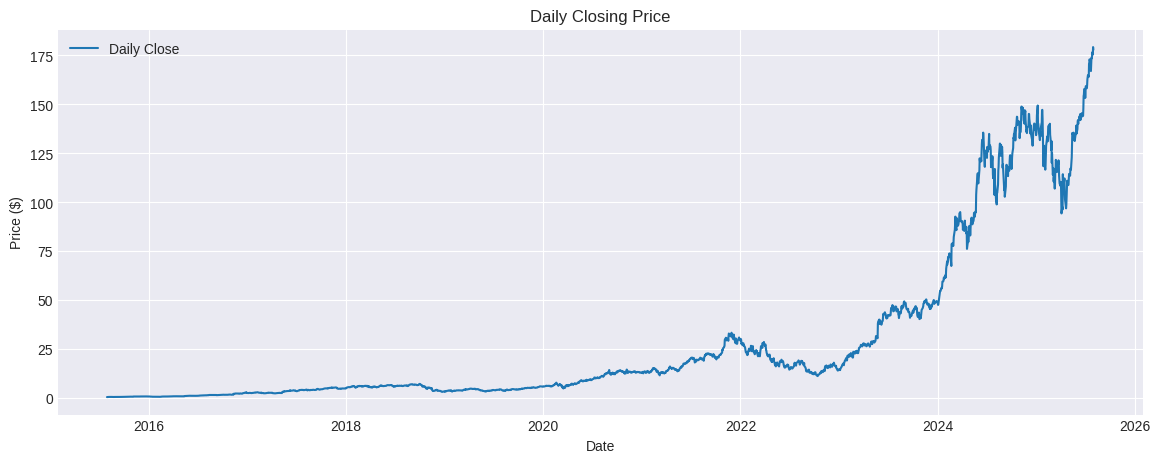

/tmp/ipython-input-851335266.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('Date').resample('M')['Close/Last'].last()


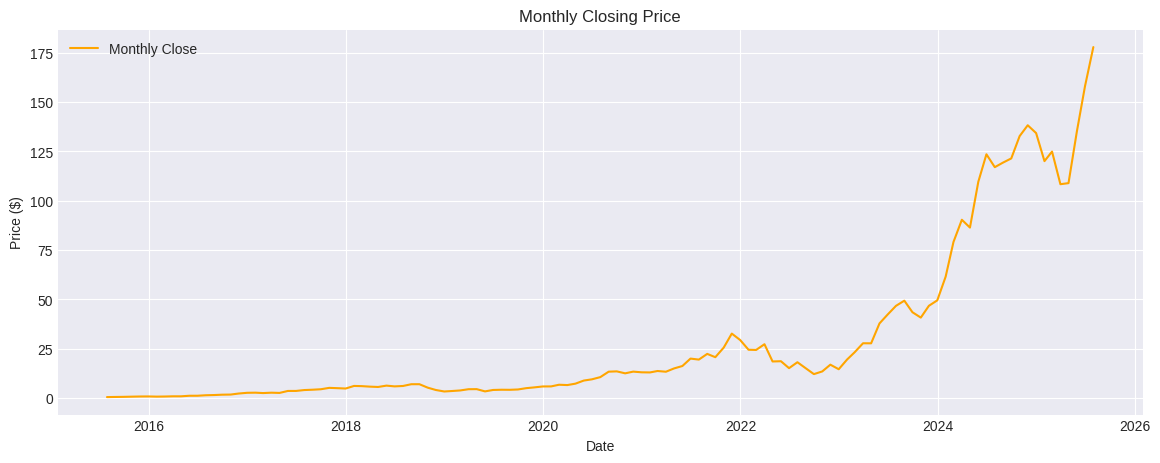

/tmp/ipython-input-851335266.py:21: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = df.set_index('Date').resample('Y')['Close/Last'].last()


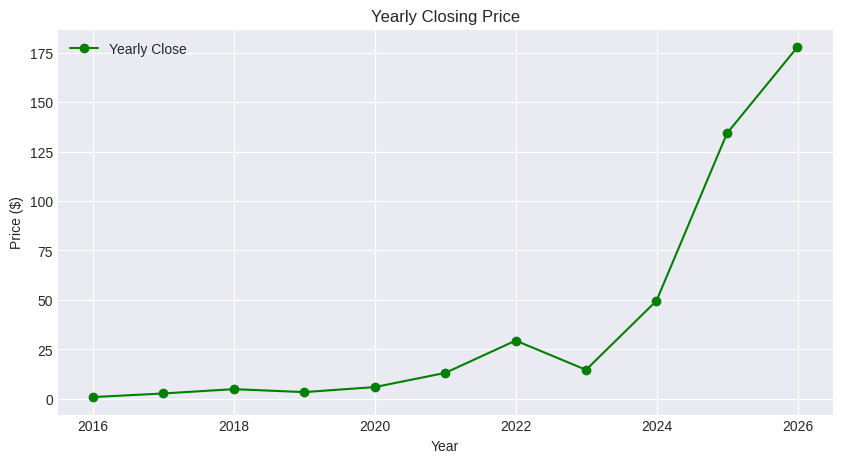

In [6]:
# Daily closing price
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Close/Last'], label='Daily Close')
plt.title('Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Monthly closing price (last trading day of each month)
monthly = df.set_index('Date').resample('M')['Close/Last'].last()
plt.figure(figsize=(14,5))
plt.plot(monthly.index, monthly.values, label='Monthly Close', color='orange')
plt.title('Monthly Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Yearly closing price (last trading day of each year)
yearly = df.set_index('Date').resample('Y')['Close/Last'].last()
plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly.values, marker='o', label='Yearly Close', color='green')
plt.title('Yearly Closing Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## 3. Compare Long-Term Growth vs. Short-Term Fluctuations
- Overlay daily price with 50-day and 200-day moving averages

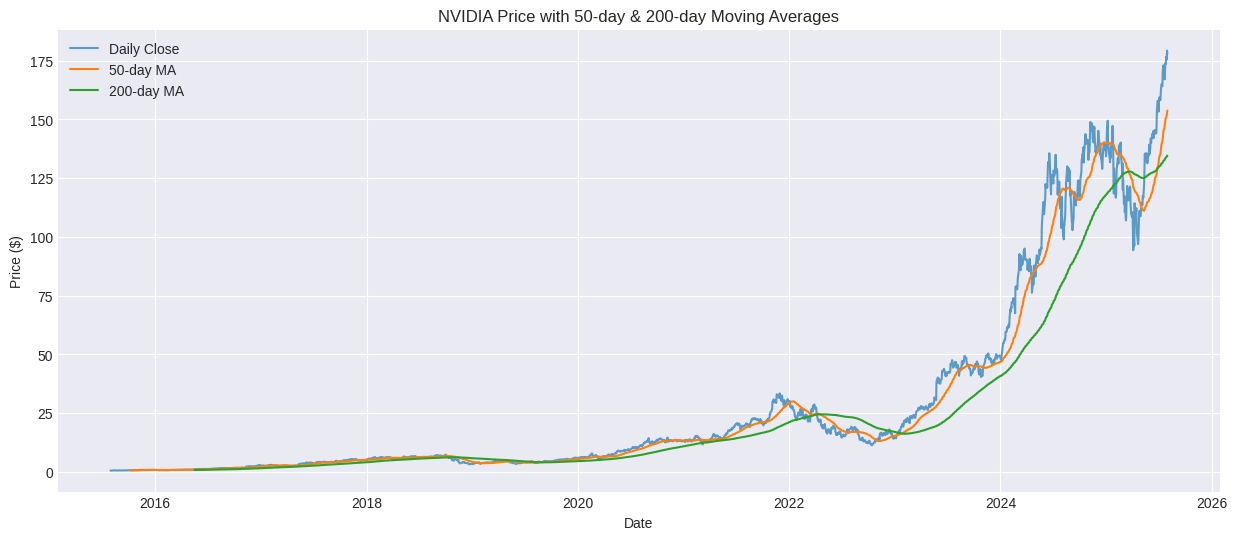

In [8]:
df['MA50'] = df['Close/Last'].rolling(50).mean()
df['MA200'] = df['Close/Last'].rolling(200).mean()

plt.figure(figsize=(15,6))
plt.plot(df['Date'], df['Close/Last'], label='Daily Close', alpha=0.7)
plt.plot(df['Date'], df['MA50'], label='50-day MA')
plt.plot(df['Date'], df['MA200'], label='200-day MA')
plt.title('NVIDIA Price with 50-day & 200-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## 4. Daily Returns & Volatility

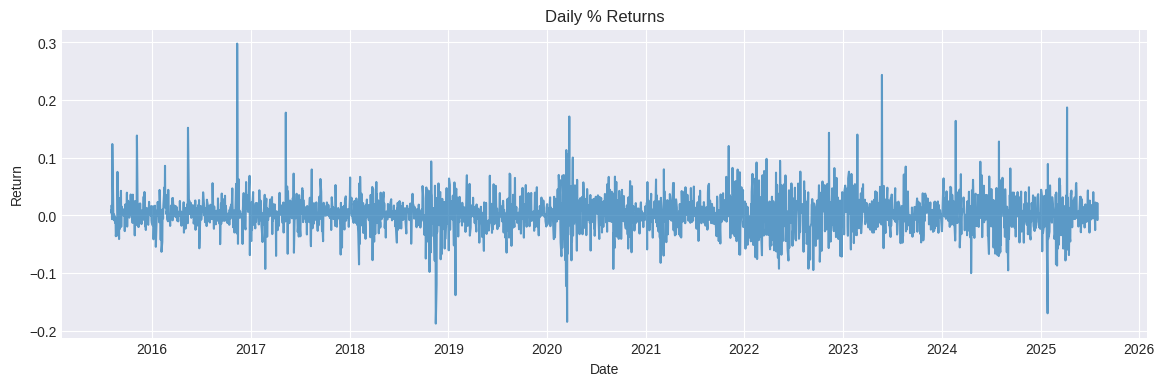

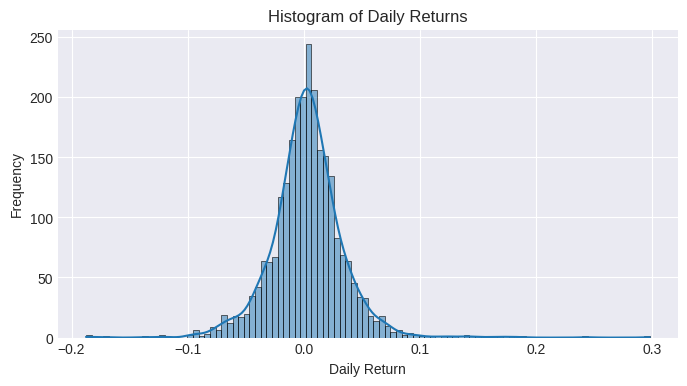

In [9]:
# Calculate daily % returns
df['Return'] = df['Close/Last'].pct_change()

# Plot daily returns
plt.figure(figsize=(14,4))
plt.plot(df['Date'], df['Return'], alpha=0.7)
plt.title('Daily % Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Histogram of returns
plt.figure(figsize=(8,4))
sns.histplot(df['Return'].dropna(), bins=100, kde=True)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

### Rolling 30-day Volatility

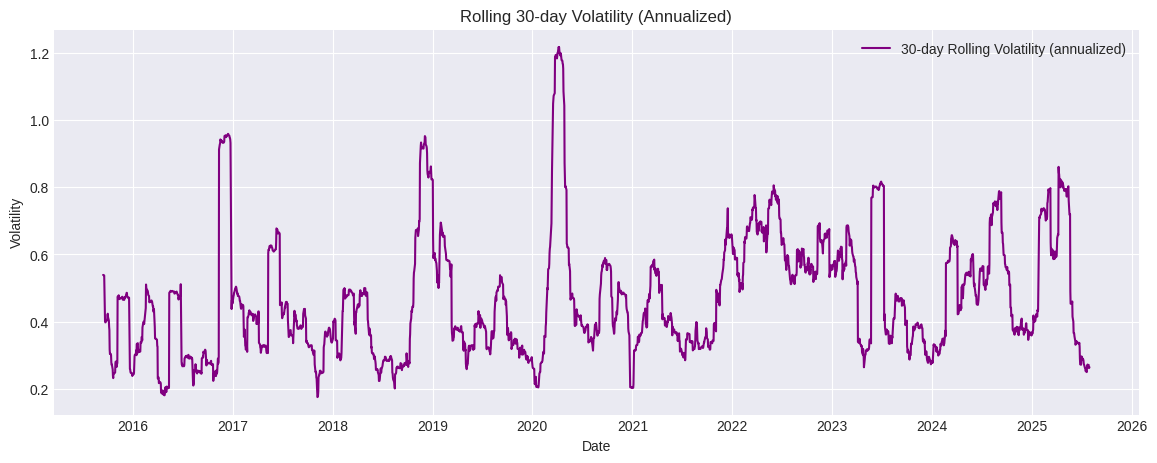

In [10]:
df['Volatility30'] = df['Return'].rolling(30).std() * np.sqrt(252)  # annualized

plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Volatility30'], color='purple', label='30-day Rolling Volatility (annualized)')
plt.title('Rolling 30-day Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## 5. Volume vs. Price Movement

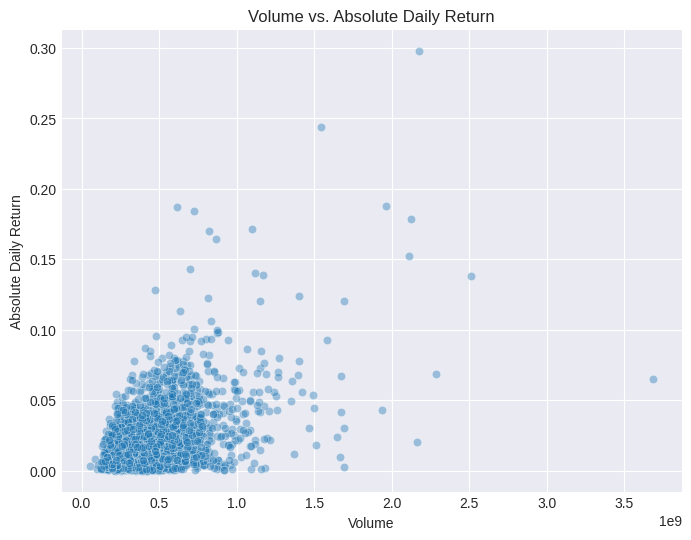

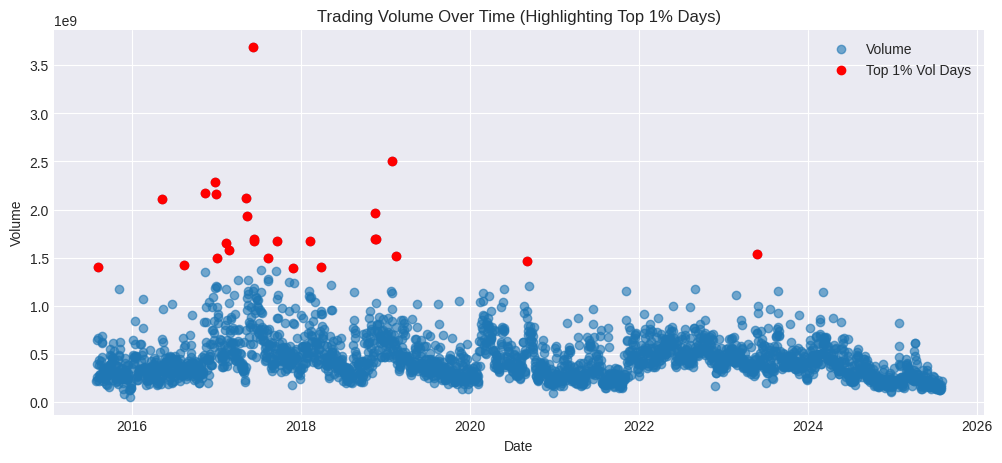

In [11]:
# Absolute return vs. trading volume
df['AbsReturn'] = df['Return'].abs()

plt.figure(figsize=(8,6))
sns.scatterplot(x='Volume', y='AbsReturn', data=df, alpha=0.4)
plt.xlabel('Volume')
plt.ylabel('Absolute Daily Return')
plt.title('Volume vs. Absolute Daily Return')
plt.show()

# Highlight days with top 1% volume
threshold = df['Volume'].quantile(0.99)
high_vol = df[df['Volume'] > threshold]
plt.figure(figsize=(12,5))
plt.scatter(df['Date'], df['Volume'], label='Volume', alpha=0.6)
plt.scatter(high_vol['Date'], high_vol['Volume'], color='r', label='Top 1% Vol Days')
plt.title('Trading Volume Over Time (Highlighting Top 1% Days)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

## 6. High-Low Range Analysis (Intraday Range)

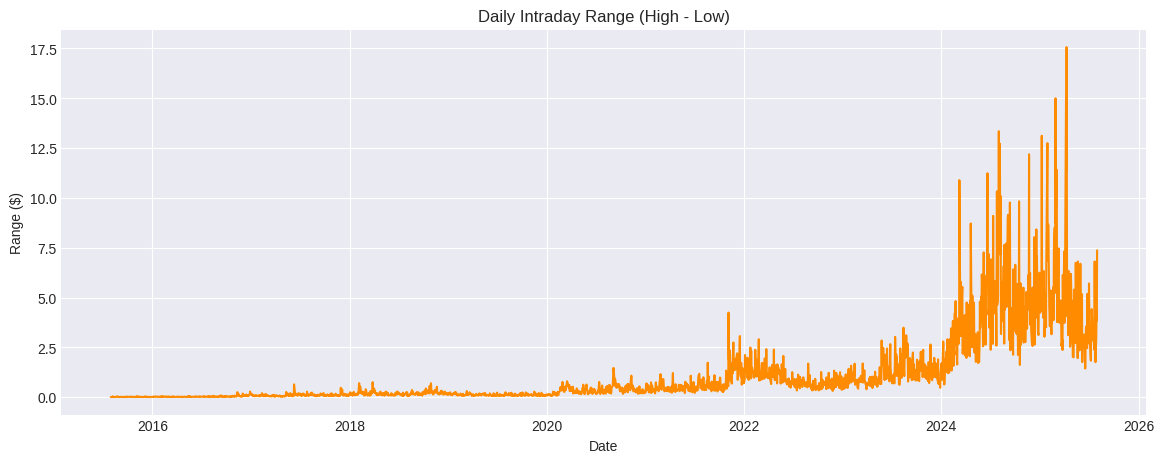

In [12]:
# Intraday range
df['Range'] = df['High'] - df['Low']
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Range'], label='Intraday Range', color='darkorange')
plt.title('Daily Intraday Range (High - Low)')
plt.xlabel('Date')
plt.ylabel('Range ($)')
plt.show()

## 7. Yearly & Monthly Seasonality

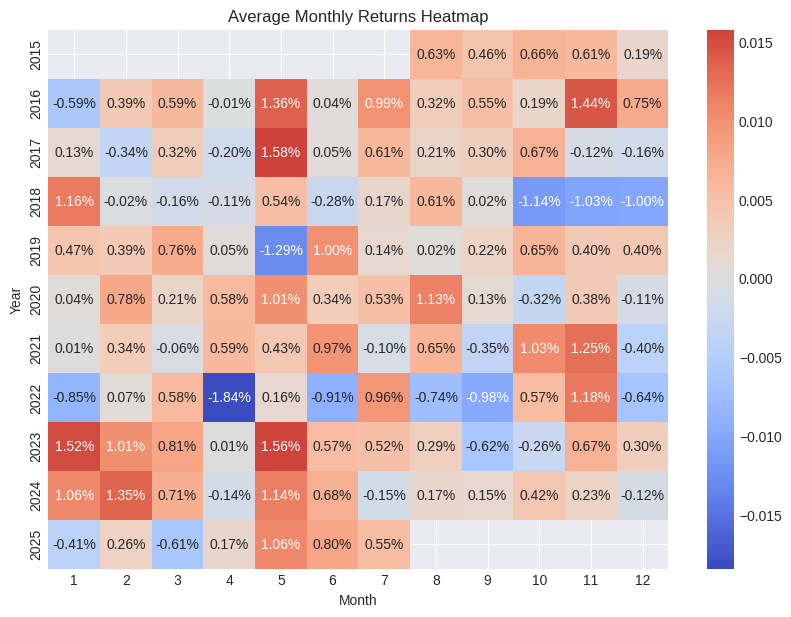

/tmp/ipython-input-3006486694.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_monthly.index, y=avg_monthly.values, palette='Blues')


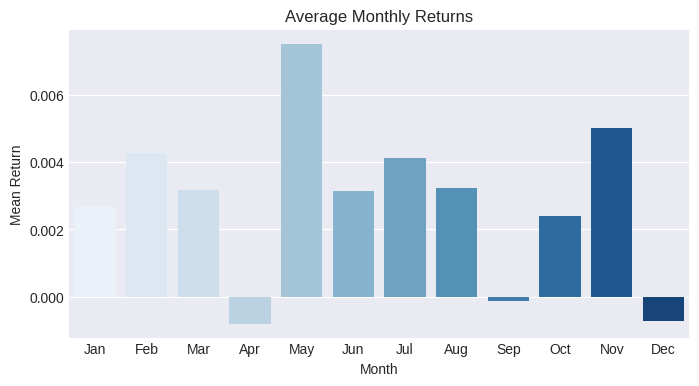

In [13]:
# Add year/month columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by year/month for mean returns
monthly_returns = df.groupby(['Year', 'Month'])['Return'].mean().unstack()
plt.figure(figsize=(10,7))
sns.heatmap(monthly_returns, annot=True, fmt='.2%', cmap='coolwarm', center=0)
plt.title('Average Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()

# Average return per month across all years
avg_monthly = df.groupby('Month')['Return'].mean()
plt.figure(figsize=(8,4))
sns.barplot(x=avg_monthly.index, y=avg_monthly.values, palette='Blues')
plt.xticks(ticks=range(0,12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Average Monthly Returns')
plt.ylabel('Mean Return')
plt.xlabel('Month')
plt.show()

## 8. Conclusions / Observations

- Inspect which months/years had large price gains or losses
- Identify periods of high volatility or large price swings
- Check if high volume days tend to coincide with big price moves
- See if there are strong monthly/seasonal patterns

---

**Feel free to experiment with different rolling windows, groupings, or visualizations!**